# Ground-state energies through ionic-relaxation path from pretrained m3gnet model

In [6]:
import numpy             as np
import pandas            as pd
import pytorch_lightning as pl
import ML_library        as MLL
import matplotlib.pyplot as plt
import matgl
import os
import shutil
import warnings
import glob
import ase 

from os                        import path
from __future__                import annotations
from dgl.data.utils            import split_dataset
from mp_api.client             import MPRester
from pytorch_lightning.loggers import CSVLogger
from matgl.ext.pymatgen        import Structure2Graph, get_element_list
from matgl.graph.data          import M3GNetDataset, MGLDataLoader, collate_fn_efs
from matgl.models              import M3GNet
from matgl.utils.training      import PotentialLightningModule
from ase.io                    import read, write
from ase.io.vasp               import write_vasp_xdatcar
from matgl.ext.ase             import M3GNetCalculator
from pymatgen.io.ase           import AseAtomsAdaptor

# To suppress warnings for clearer output
warnings.simplefilter('ignore')

In [15]:
data_train_path = 'm3gnet_dataset.xlsx'

# Define paths to pretrained model and structure to be relaxed
# Materials Project pretrained model as default
#model_load_path = 'finetuned_model'
model_load_path = None
model_load_path = 'M3GNet-MP-2021.2.8-PES' if model_load_path is None else model_load_path

# 0: material, 1: charge state, 2: ionic step
depth = 1

dpi = 100

# Load simulation data

In [10]:
# Each folder names a new column, and structure, energy, forces and stresses
# of each ionic step are loaded

if path.exists(data_train_path):
    # Load data for model training
    m3gnet_dataset = pd.read_excel(data_train_path, index_col=0, header=[0,1,2])
else:
    # Path to dataset, structured as:
    # path_to_dataset
    #     material_i
    #         defect_i
    #             simulation_i (containing vasprun.xml)
    path_to_dataset = '../../../Desktop/defects/gamma'

    # Extract the data
    source_m3gnet_dataset = MLL.extract_vaspruns_dataset(path_to_dataset)
    #source_m3gnet_dataset.to_excel(data_train_path)

source_m3gnet_dataset


BiSBr

BiSeBr

BiSeI

BiSI
	as_1_Bi_on_S_-1
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_-2
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_0
	as_1_Bi_on_S_1
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_2
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_3
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_4
	as_1_Bi_on_S_5
	as_1_I_on_Bi_-1
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasp

BiSI  \
                                        BiSI_as_1_Bi_on_S_-1   
                                      BiSI_as_1_Bi_on_S_-1_0   
structure  [[3.15281399 2.93861474 5.6361836 ] Bi, [0.630...   
energy                                            -289.12365   
force      [[-1.92632264, -0.56138606, 1.59567384], [7.39...   
stress     [[-9.387791068, 0.5969766500000001, 0.44902389...   
nelect                                                 682.0   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_1   
structure  [[3.05988314 2.91153208 5.71316315] Bi, [0.987...   
energy                                            -316.33355   
force      [[-0.90385412, -0.39068356, 1.13836959], [0.62...   
stress     [[-1.22633487, 0.35682851800000004, -0.4239112...   
nelect                                                 682.0   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_2   
structure  [[3.05824862 2.91105576 5.71451708] Bi, [0.993...   
energy                                            -316.35309   
force      [[-0.88559512, -0.38374943, 1.12920028], [0.56...   
stress     [[-1.199570183, 0.355605151, -0.428876207], [0...   
nelect                                                 682.0   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_3   
structure  [[3.00950645 2.89076728 5.77404553] Bi, [1.043...   
energy                                           -321.140502   
force      [[-0.35301477, -0.33939464, 0.69170336], [0.03...   
stress     [[-0.331221996, 0.340032651, -0.37534631900000...   
nelect                                                 682.0   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_4   
structure  [[2.93082376 2.85801638 5.87013983] Bi, [1.123...   
energy                                           -324.119367   
force      [[0.40239548, -0.40297129, 0.14670017], [-0.77...   
stress     [[-0.07879467000000001, 0.310052009, -0.271773...   
nelect                                                 682.0   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_5   
structure  [[2.93191615 2.82193713 5.90967382] Bi, [1.099...   
energy                                           -326.452302   
force      [[0.39597356, -0.26062563, -0.17949639], [-0.4...   
stress     [[-0.096809425, 0.279244603, -0.30016127400000...   
nelect                                                 682.0   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_6   
structure  [[2.93254654 2.80111726 5.93248738] Bi, [1.085...   
energy                                           -326.847608   
force      [[0.39337901, -0.1779908, -0.3629015], [-0.342...   
stress     [[-0.24790909600000002, 0.250699222, -0.311515...   
nelect                                                 682.0   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_7   
structure  [[2.96098326 2.77729779 5.91873229] Bi, [1.053...   
energy                                           -327.866389   
force      [[0.24801109, -0.09464026, -0.18593179], [-0.1...   
stress     [[-0.221206385, 0.236151664, -0.339607759], [0...   
nelect           

# Split data into train-validation-test sets

### Decide if we split in terms of mateiral, defect state or simulation directly

In [11]:
# Clone (copy) the DataFrame
m3gnet_dataset = source_m3gnet_dataset.copy()

# Remove the outer (top-level) column index up to depth-1 level
for i in range(depth):
    m3gnet_dataset.columns = m3gnet_dataset.columns.droplevel(0)

### Splitting into train-validation-test sets

In [13]:
# Check if data has been already split, else do it randomly

path_to_test_labels = 'test_labels.txt'

if path.exists(path_to_test_labels):
    # Read labels splitting (which are strings)
    test_labels = np.genfromtxt(path_to_test_labels, dtype='str').tolist()
else:
    print('Error: test labels not available')

# Use the loaded/computed labels to generate split datasets
test_dataset = m3gnet_dataset[test_labels]

n_test = np.shape(test_dataset)[1]

print(f'Using {n_test} samples to test')

Using 2584 samples to test


# Structure Relaxation

To perform structure relaxation, we use the Relaxer class. Here, we demonstrate the relaxation of a simple CsCl structure.

In [16]:
# Load the default pre-trained model
pot = matgl.load_model(model_load_path)

# Define the M3GNet calculator
calc = M3GNetCalculator(pot)

In [115]:
# Remove last column, of ionic step
m3gnet_dataset = test_dataset.copy()
m3gnet_dataset.columns = m3gnet_dataset.columns.droplevel(-1)

# Define unique columns
unique_colums = np.unique(m3gnet_dataset.columns)

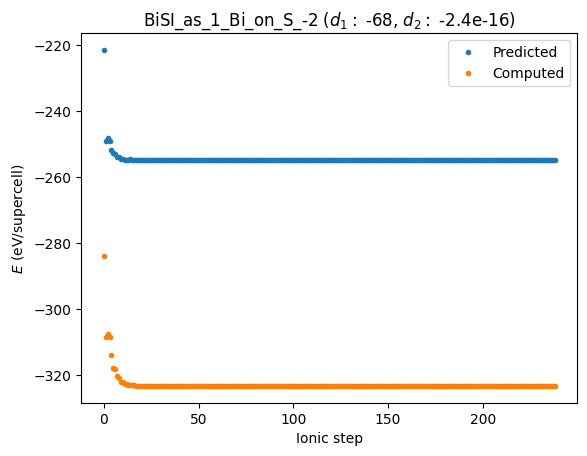

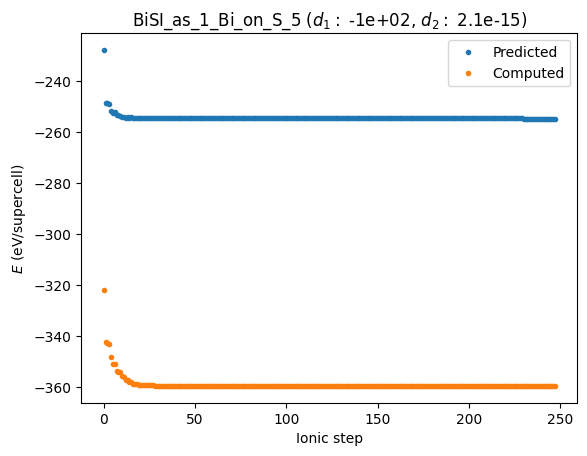

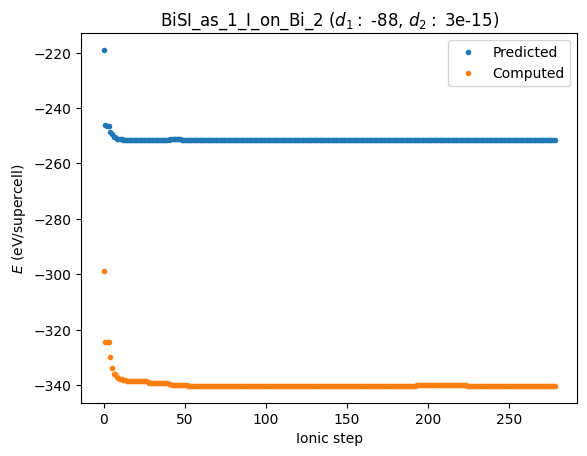

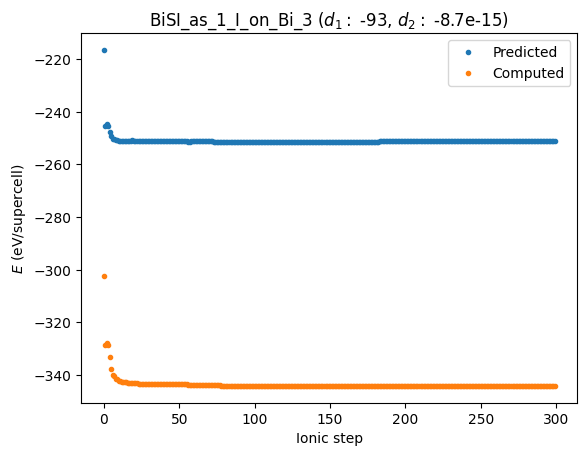

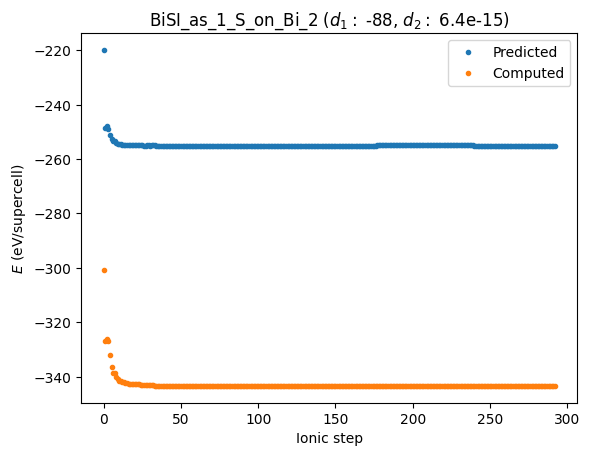

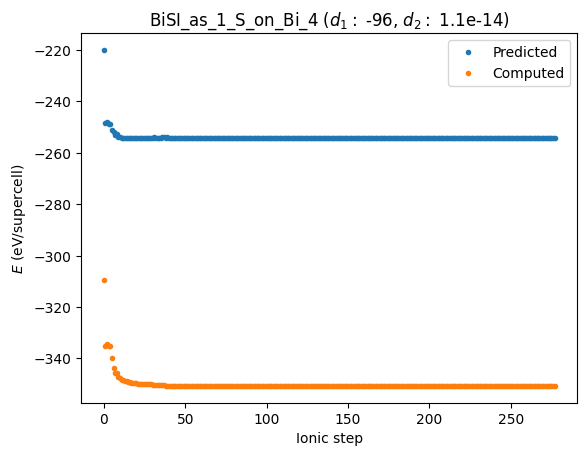

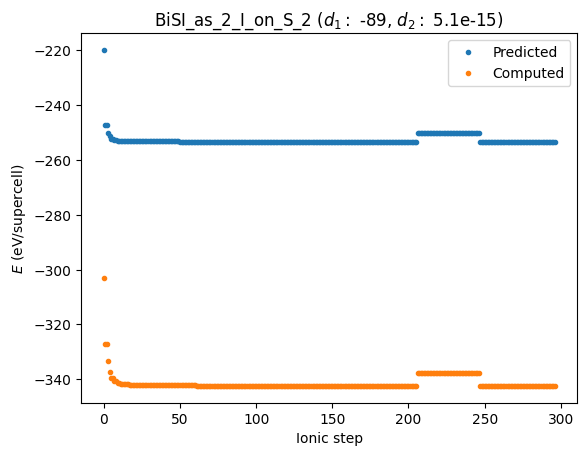

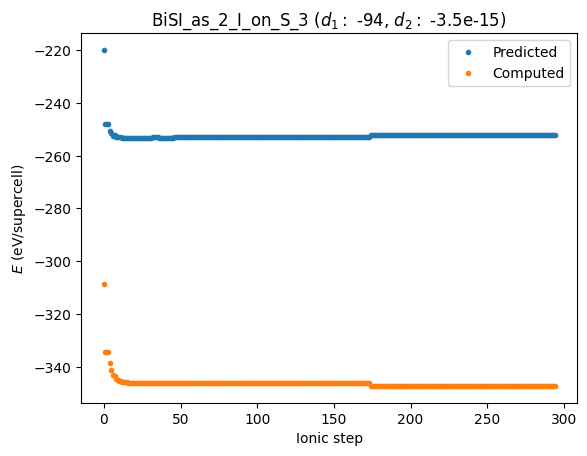

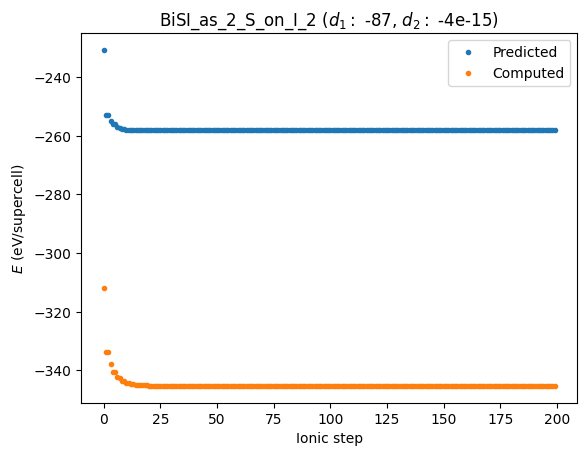

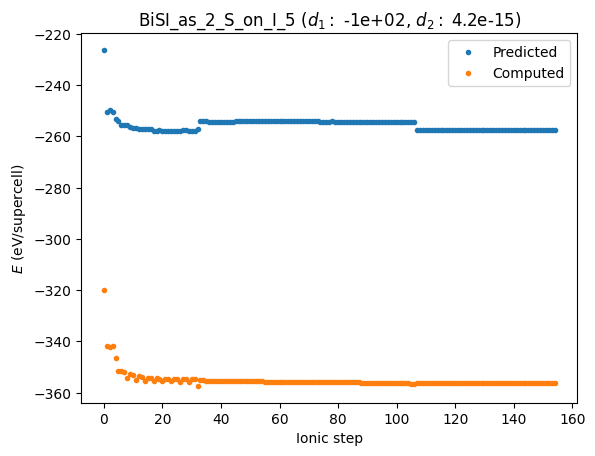

In [145]:
# Run over each ionic step and predict the energy with a single-shot calculation
offsets    = []
accuracies = []
for column_name in unique_colums:
    temp_data = m3gnet_dataset[column_name]
    
    # Initialize list for energies
    computed_energies  = []
    predicted_energies = []
    
    for i in range(np.shape(temp_data)[1]):
        # Load structure and computed (DFT) energy
        atoms           = temp_data.iloc[:, i].structure
        computed_energy = temp_data.iloc[:, i].energy

        # Load atoms adapter and adapt structure
        ase_adaptor = AseAtomsAdaptor()
        atoms = ase_adaptor.get_atoms(atoms)

        # Predict energy (ML-IAP)
        atoms.set_calculator(calc)
        predicted_energy = float(atoms.get_potential_energy())

        computed_energies.append(computed_energy)
        predicted_energies.append(predicted_energy)
    
    # Pass to numpy array
    computed_energies  = np.array(computed_energies)
    predicted_energies = np.array(predicted_energies)
    
    # Compute metrics
    offset   = MLL.compute_offset(computed_energies, predicted_energies)
    accuracy = MLL.compute_accuracy(computed_energies, predicted_energies, offset)
    
    # Append metrics
    offsets.append(offset)
    accuracies.append(accuracy)
    
    # Plot energy comparison
    plt.title(f'{column_name} ($d_1:$ {offset:.2g}, $d_2:$ {accuracy:.2g})')  # eV/supercell
    plt.plot(predicted_energies, '.', label='Predicted')
    plt.plot(computed_energies,  '.', label='Computed')
    plt.legend(loc='best')
    plt.xlabel('Ionic step')
    plt.ylabel('$E$ (eV/supercell)')
    plt.show()

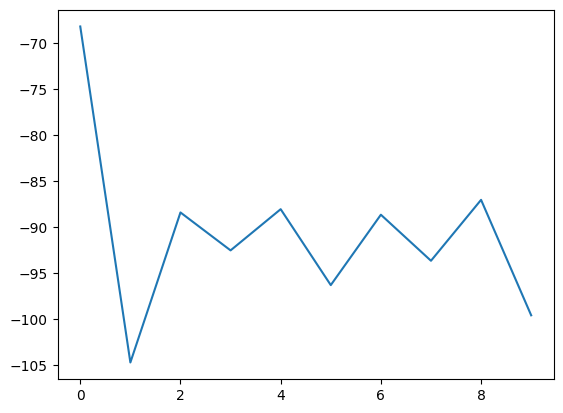

In [146]:
plt.plot(offsets)

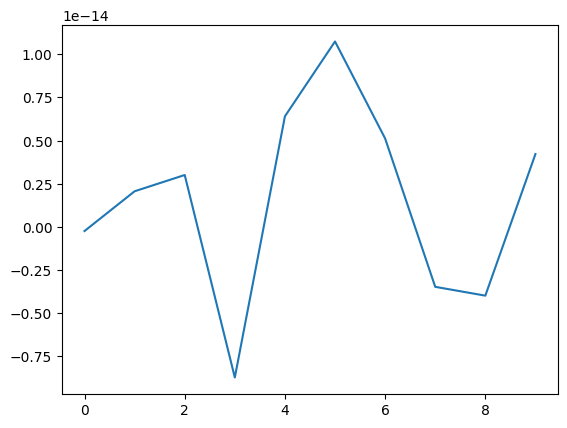

In [147]:
plt.plot(accuracies)